## Get data

In [85]:
import yfinance as yf
import pandas as pd

tickers = ["CVX", "COP"]
df = None
for tick in tickers:
    ticker = yf.Ticker(tick)
    income = ticker.financials
    balance = ticker.balance_sheet
    d = pd.concat(
        (
            income.loc["Net Income"],
            income.loc["Total Revenue"],
            balance.loc["Total Assets"],
            balance.loc["Stockholders Equity"]
        ),
        axis=1
    )
    d.columns = ["netinc", "revenue", "assets", "equity"]
    d.index.name = "year"
    d["ticker"] = tick
    df = pd.concat((df, d))
df.index = df.index.map(lambda x: x.year)
df = df.sort_values(by=["ticker", "year"])
df = df.reset_index().set_index(["ticker", "year"])

## Compute ratios

In [86]:
for col in ["assets", "equity"]:
    df[col] = df.groupby("ticker", group_keys=False)[col].apply(
        lambda x: x.rolling(2).mean()
    )
df = df.dropna()
df["roe"] = df.netinc / df.equity
df["margin"] = df.netinc / df.revenue 
df["turnover"] = df.revenue / df.assets
df["multiplier"] = df.assets / df.equity

## Plot

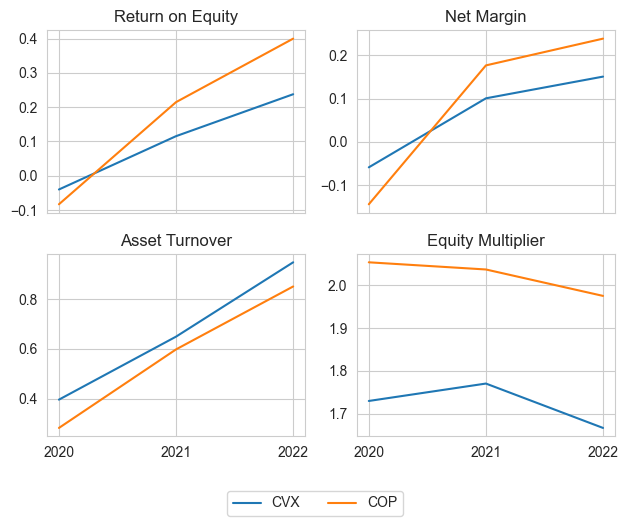

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True)
for tick in tickers:
    ser = df.xs(tick, level="ticker").roe
    ax1.plot(ser, label=tick)
    ser = df.xs(tick, level="ticker").margin
    ax2.plot(ser)
    ser = df.xs(tick, level="ticker").turnover
    ax3.plot(ser)
    ser = df.xs(tick, level="ticker").multiplier
    ax4.plot(ser)
ax1.set_title("Return on Equity")
ax2.set_title("Net Margin")
ax3.set_title("Asset Turnover")
ax4.set_title("Equity Multiplier")
ax3.set_xlabel(None)
ax4.set_xlabel(None)
ax3.set_xticks(df.index.unique('year'))
ax4.set_xticks(df.index.unique('year'))
fig.legend(bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=2)
fig.tight_layout()  